analyzing and cleaning:

III. 2015- 2023 The Employment Cost Index (ECI):
Link to Dataset: Tables : U.S. Bureau of Labor Statistics
File format: Excel
Approximate File size: 2.4MB
Approximate Number of records: 35,622
Purpose: to measure the change in the hourly labor cost to employers over time.

IV. 2015 - 2023 Consumer Price Index:
Link to Dataset: Archived Consumer Price Index Supplemental Files : U.S. Bureau of
Labor Statistics
File format: Excel
Approximate File size: 12.8KB
Approximate Number of records: 63
Purpose: to monitor inflation over time.

In [1]:
!pip install pyspark dask pandas matplotlib openpyxl

Defaulting to user installation because normal site-packages is not writeable


ECI

we chose CIU1010000000000A (Civilian workers, wage growth)

This is the most commonly used ECI measure for:
- Wage inflation
- Labor cost comparison vs consumer inflation
- Economic reports
- Federal Reserve analyses

It is directly comparable to CPI-W because they are both:
- Percent changes (not raw indices)
- Quarterly 12-month percent changes
- Standard indicators of wage growth vs living cost growth

Using this series allows you to produce:
- Nominal wage growth
- Inflation (CPI-W)
- Real wage growth (ECI − CPI-W)

This code loads the Employment Cost Index (ECI) Excel file, cleans it, and selects a specific wage-growth series for civilian workers (CIU1010000000000A). It reshapes the quarterly data into a long format, extracts the year and quarter from each column label, and keeps only Q4 values, which represent the official 12-month wage growth measure used by economists. The script then aggregates the data into a yearly wage-growth table (2015–2023) and plots the trend to visualize how wage inflation changed over time. T

Using ECI series: CIU1010000000000A


/home/jovyan/.local/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,SeriesID,Qtr1\n2015,Qtr2\n2015,Qtr3\n2015,Qtr4\n2015,Qtr1\n2016,Qtr2\n2016,Qtr3\n2016
0,CIU1010000000000A,2.6,2.0,2.0,2.0,1.9,2.3,2.3


ECI yearly wage growth (%), Q4 12-month change:


,year,eci_pct_change
0,2015,2.0
1,2016,2.2
2,2017,2.6
3,2018,2.9
4,2019,2.7
5,2020,2.5
6,2021,4.0
7,2022,5.1
8,2023,4.2


Index(['year', 'eci_pct_change'], dtype='object')


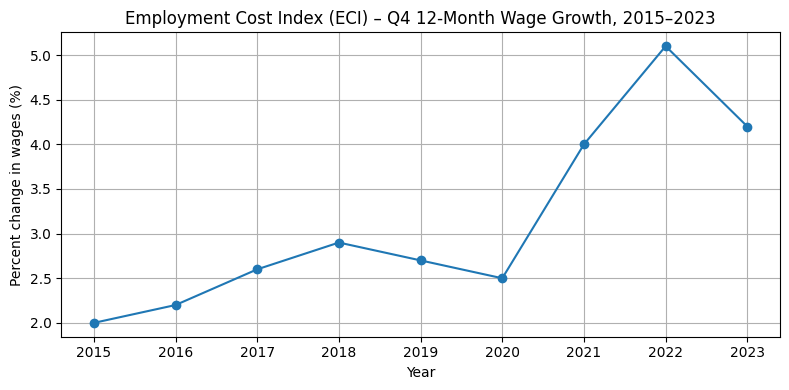

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

ECI_XLSX = "data/ECI.xlsx"

# Read ECI Excel (skip metadata rows so "Series ID / Qtr1\n2015 / ..." are headers)
eci_raw = pd.read_excel(ECI_XLSX, engine="openpyxl", skiprows=3)
eci_raw = eci_raw.dropna(axis=1, how="all")

# Renaming first column to SeriesID
first_col_name = eci_raw.columns[0]
eci_raw = eci_raw.rename(columns={first_col_name: "SeriesID"})

TARGET_SERIES = "CIU1010000000000A"  # Civilian workers, wages & salaries, 12-month % change
eci_row = eci_raw[eci_raw["SeriesID"] == TARGET_SERIES].copy()

print("Using ECI series:", TARGET_SERIES)
display(eci_row.iloc[:, :8])

# organizing quarter columns into a long format
eci_long = eci_row.melt(
    id_vars=["SeriesID"],
    var_name="quarter_label",
    value_name="eci_pct_change"
)

# Keeping only numeric ECI values
eci_long["eci_pct_change"] = pd.to_numeric(eci_long["eci_pct_change"], errors="coerce")
eci_long = eci_long.dropna(subset=["eci_pct_change"])

# Extracting year and quarter from labels like "Qtr4\n2018"
eci_long["year"] = (
    eci_long["quarter_label"]
    .astype(str)
    .str.extract(r"(\d{4})", expand=False)
    .astype(int)
)
eci_long["quarter"] = (
    eci_long["quarter_label"]
    .astype(str)
    .str.extract(r"(Qtr\d)", expand=False)
)

# Using only Q4 values (12-month change at the end of each year)
eci_q4 = eci_long[eci_long["quarter"] == "Qtr4"].copy()

eci_yearly = (
    eci_q4.groupby("year")["eci_pct_change"]
    .mean()
    .reset_index()
    .sort_values("year")
)

print("ECI yearly wage growth (%), Q4 12-month change:")
display(eci_yearly)

print(eci_yearly.columns) 

# Plot ECI
plt.figure(figsize=(8, 4))
plt.plot(eci_yearly["year"], eci_yearly["eci_pct_change"], marker="o", linestyle="-")
plt.title("Employment Cost Index (ECI) – Q4 12-Month Wage Growth, 2015–2023")
plt.xlabel("Year")
plt.ylabel("Percent change in wages (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# Make column name consistent with BLS files
eci_yearly_parquet = eci_yearly.copy()
eci_yearly_parquet["Year"] = eci_yearly_parquet["year"].astype(int)
eci_yearly_parquet.drop(columns=["year"], inplace=True)

# Save as Parquet
eci_parquet_path = "data/eci_yearly_q4.parquet"
eci_yearly_parquet.to_parquet(eci_parquet_path, index=False)
print("Wrote ECI yearly parquet to:", eci_parquet_path)

eci_yearly_parquet.head()

Wrote ECI yearly parquet to: data/eci_yearly_q4.parquet


,eci_pct_change,Year
0,2.0,2015
1,2.2,2016
2,2.6,2017
3,2.9,2018
4,2.7,2019


CLI Data Analyzation:

What the code does:
- Reads nine messy CPI-W Excel files (2015–2023).
- Automatically detects the real header row inside each file.
- Extracts only key economic categories (e.g., Food, Energy, Shelter).
- Pulls each category’s relative importance and annual inflation percentage.
- Builds a clean dataset with one row per (year, category).
- Creates standardized yearly inflation features for downstream modeling.

In [4]:
import pandas as pd
from collections import OrderedDict

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

DATA_PATH = "data/CLI/"

excel_files = OrderedDict({
    2015: DATA_PATH + "CPI-W_201512.xlsx",
    2016: DATA_PATH + "CPI-W_201612.xlsx",
    2017: DATA_PATH + "cpi-w-201712.xlsx",
    2018: DATA_PATH + "cpi-w-201812.xlsx",
    2019: DATA_PATH + "cpi-w-201912.xlsx",
    2020: DATA_PATH + "cpi-w-202012.xlsx",
    2021: DATA_PATH + "cpi-w-202112.xlsx",
    2022: DATA_PATH + "cpi-w-202212.xlsx",
    2023: DATA_PATH + "cpi-w-202312.xlsx",
})

TARGET_CATEGORIES = [
    "All items",
    "All items less food and energy",
    "Food",
    "Energy",
    "Shelter",
    "Medical care services",
    "Transportation services",
]

In [5]:
records = []

def normalize(s):
    return str(s).lower().replace("\n", " ").strip()

for year, path in excel_files.items():
    print(f"\nReading {path} for report year {year}...")
    
    df_raw = pd.read_excel(path, engine="openpyxl", header=None)
    
    # find header row with "Indent Level"
    header_row_idx = None
    for i in range(len(df_raw)):
        first_cell = str(df_raw.iloc[i, 0]).strip()
        if first_cell.lower().startswith("indent"):
            header_row_idx = i
            break
    if header_row_idx is None:
        print("  ERROR: no 'Indent Level' row found")
        continue
    
    header = df_raw.iloc[header_row_idx].tolist()
    df = df_raw.iloc[header_row_idx + 1:].copy()
    df.columns = header
    
    print("  Header row index:", header_row_idx)
    print("  First few columns after reheader:", list(df.columns[:8]))
    print("  First 3 data rows:")
    print(df.head(3))

    col_norm = {col: normalize(col) for col in df.columns}

    # --- key columns ---
    # Expenditure category
    exp_col = None
    for col, norm in col_norm.items():
        if "expenditure" in norm and "category" in norm:
            exp_col = col
            break
    if exp_col is None:
        print("  ERROR: no 'Expenditure category' column")
        continue

    # Relative importance
    rel_col = None
    for col, norm in col_norm.items():
        if "relative" in norm and "importance" in norm:
            rel_col = col
            break
    if rel_col is None:
        print(f"  WARNING: no relative-importance column for {year}")
        continue
    print(f"  Using relative-importance column: {rel_col!r}")

    # Annual % change using only the FIRST "Unadjusted percent change" column by position
    annual_idx = None
    for j, col in enumerate(df.columns):
        if "unadjusted percent change" in normalize(col):
            annual_idx = j
            break
    if annual_idx is None:
        print(f"  WARNING: no 'Unadjusted percent change' column for {year}")
        continue
    print(f"  Using annual percent-change column index: {annual_idx} (name: {df.columns[annual_idx]!r})")

    # grab rows for each category (no indent filter now)
    for cat in TARGET_CATEGORIES:
        mask = df[exp_col].astype(str).str.strip() == cat
        row = df[mask]
        if row.empty:
            print(f"    NOTE: Category '{cat}' not found for {year}, skipping.")
            continue

        r = row.iloc[0]  # single row Series

        rel_val = pd.to_numeric(r[rel_col], errors="coerce")
        ann_val = pd.to_numeric(r.iloc[annual_idx], errors="coerce")  # use positional index

        records.append({
            "year": int(year),
            "category": cat,
            "relative_importance": rel_val,
            "annual_inflation_pct": ann_val,
        })

# build final table
cpi_cat_year_pd = pd.DataFrame.from_records(records)

print("\n=== CPI category-by-year features (pandas) ===")
print(cpi_cat_year_pd.head(20))
print("\nShape:", cpi_cat_year_pd.shape)
print("\nUnique years:", sorted(cpi_cat_year_pd['year'].unique()) if not cpi_cat_year_pd.empty else "[]")
print("Categories:", cpi_cat_year_pd['category'].unique() if not cpi_cat_year_pd.empty else "[]")



Reading data/CLI/CPI-W_201512.xlsx for report year 2015...
  Header row index: 3
  First few columns after reheader: ['Indent Level', 'Expenditure category', 'Relative\nimportance\nNov.\n2015', 'Unadjusted indexes', nan, nan, nan, nan]
  First 3 data rows:
  Indent Level Expenditure category Relative\nimportance\nNov.\n2015  \
4          NaN                  NaN                              NaN   
5          NaN                  NaN                              NaN   
6            0            All items                              100   

  Unadjusted indexes         NaN         NaN         NaN         NaN  \
4         Dec.\n2014  Jan.\n2015  Feb.\n2015  Mar.\n2015  Apr.\n2015   
5                NaN         NaN         NaN         NaN         NaN   
6            229.909     228.294     229.421     231.055      231.52   

         NaN         NaN  ...         NaN         NaN         NaN  \
4  May\n2015  Jun.\n2015  ...  Oct.\n2015  Nov.\n2015  Dec.\n2015   
5        NaN         NaN  

/home/jovyan/.local/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/jovyan/.local/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/jovyan/.local/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  Header row index: 3
  First few columns after reheader: ['Indent Level', 'Expenditure category', 'Relative\nimportance\nNov.\n2017', 'Unadjusted indexes', nan, nan, nan, nan]
  First 3 data rows:
  Indent Level Expenditure category Relative\nimportance\nNov.\n2017  \
4          NaN                  NaN                              NaN   
5          NaN                  NaN                              NaN   
6            0            All items                              100   

  Unadjusted indexes         NaN         NaN         NaN         NaN  \
4         Dec.\n2016  Jan.\n2017  Feb.\n2017  Mar.\n2017  Apr.\n2017   
5                NaN         NaN         NaN         NaN         NaN   
6             235.39     236.854     237.477     237.656     238.432   

         NaN         NaN  ...         NaN         NaN         NaN  \
4  May\n2017  Jun.\n2017  ...  Oct.\n2017  Nov.\n2017  Dec.\n2017   
5        NaN         NaN  ...         NaN         NaN         NaN   
6    238.609     

/home/jovyan/.local/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/jovyan/.local/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/jovyan/.local/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  Header row index: 3
  First few columns after reheader: ['Indent Level', 'Expenditure category', 'Relative\nimportance\nNov.\n2020', 'Unadjusted indexes', nan, nan, nan, nan]
  First 3 data rows:
  Indent Level Expenditure category Relative\nimportance\nNov.\n2020  \
4          NaN                  NaN                              NaN   
5          NaN                  NaN                              NaN   
6            0            All items                              100   

  Unadjusted indexes         NaN         NaN         NaN         NaN  \
4         Dec.\n2019  Jan.\n2020  Feb.\n2020  Mar.\n2020  Apr.\n2020   
5                NaN         NaN         NaN         NaN         NaN   
6            250.452     251.361     251.935     251.375     249.515   

         NaN         NaN  ...         NaN         NaN         NaN  \
4  May\n2020  Jun.\n2020  ...  Oct.\n2020  Nov.\n2020  Dec.\n2020   
5        NaN         NaN  ...         NaN         NaN         NaN   
6    249.521     

/home/jovyan/.local/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  Header row index: 3
  First few columns after reheader: ['Indent Level', 'Expenditure category', 'Relative\nimportance\nNov.\n2023', 'Unadjusted indexes', 'Unadjusted indexes', 'Unadjusted indexes', 'Unadjusted indexes', 'Unadjusted indexes']
  First 3 data rows:
  Indent Level Expenditure category Relative\nimportance\nNov.\n2023  \
4          NaN                  NaN                              NaN   
5          NaN                  NaN                              NaN   
6            0            All items                              100   

  Unadjusted indexes Unadjusted indexes Unadjusted indexes Unadjusted indexes  \
4         Dec.\n2022         Jan.\n2023         Feb.\n2023         Mar.\n2023   
5                NaN                NaN                NaN                NaN   
6            291.051            293.565            295.057            296.021   

  Unadjusted indexes Unadjusted indexes Unadjusted indexes  ...  \
4         Apr.\n2023          May\n2023         Jun.\

In [6]:
import pandas as pd

# Clean types once
cpi_cat_year_pd["year"] = cpi_cat_year_pd["year"].astype(int)
cpi_cat_year_pd["annual_inflation_pct"] = (
    cpi_cat_year_pd["annual_inflation_pct"].astype(float)
)

# Save to CSV instead of parquet
out_path = "data/CLI/cpi_category_inflation_2015_2023.csv"
cpi_cat_year_pd.to_csv(out_path, index=False)
print("Wrote:", out_path)

# displaying output of csv
print(cpi_cat_year_pd.head())


Wrote: data/CLI/cpi_category_inflation_2015_2023.csv
   year                        category  relative_importance  \
0  2015                       All items              100.000   
1  2015  All items less food and energy               76.194   
2  2015                            Food               15.066   
3  2015                          Energy                8.740   
4  2015                         Shelter               31.787   

   annual_inflation_pct  
0                   0.4  
1                   2.1  
2                   0.7  
3                 -13.0  
4                   3.2  


In [ ]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Big Data Application - CPI Integration")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

cpi_cat_year_spark = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("data/CLI/cpi_category_inflation_2015_2023.csv")
)
cpi_cat_year_spark.show(10)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/08 04:14:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
len(cpi_cat_year_pd)

In [ ]:
import matplotlib.pyplot as plt

# Ensure sorted for plots
plot_df = cpi_cat_year_pd.sort_values(["year", "category"])

# Pivot: rows = year, columns = category, values = annual inflation %
pivot = plot_df.pivot_table(
    index="year",
    columns="category",
    values="annual_inflation_pct"
)

# ---------- 1) Full multi-category trend ----------
plt.figure(figsize=(10, 6))

for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=col)

plt.axhline(0, linestyle="--", linewidth=0.8)
plt.title("CPI-W Annual Inflation by Major Category (2015–2023)")
plt.xlabel("Year")
plt.ylabel("Annual inflation rate (%)")
plt.xticks(pivot.index)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Combining ECI & CLI DATA

Code Summary:
- Selects the CPI-W “All items” series from the CPI dataset and keeps only two columns:
1. year
2. annual_inflation_pct → renamed to cpi_inflation_pct
- Sorts CPI values by year so they align properly with ECI data.
- Merges CPI and ECI datasets on the year column, producing a single table containing:
1. nominal wage growth (eci_pct_change)
2. inflation (cpi_inflation_pct)
3. their relationship across time
- Computes real wage growth, defined as: real_wage_growth = ECI wage growth − CPI inflation

Creates a visualizations:
- ECI wage growth vs CPI inflation over time to show how wages and prices move relative to each other.
- Convert macroeconomic indicators into model-ready features and visualize how labor costs interact with living costs.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Grabbing CPI "All items"

cpi_source = cpi_cat_year_pd  

cpi_all = (
    cpi_source[cpi_source["category"] == "All items"]
    [["year", "annual_inflation_pct"]]
    .rename(columns={"annual_inflation_pct": "cpi_inflation_pct"})
    .sort_values("year")
)

print("CPI-W All-items inflation (%):")
display(cpi_all)

# Merge ECI (eci_yearly) and CPI (cpi_all) on year

combined = (
    eci_yearly.merge(cpi_all, on="year", how="inner")
    .sort_values("year")
    .reset_index(drop=True)
)

# Real wage growth = nominal wage growth – inflation
combined["real_wage_growth"] = (
    combined["eci_pct_change"] - combined["cpi_inflation_pct"]
)

print("Combined ECI + CPI-W (All items):")
display(combined)

# Plotting the nominal wage growth vs inflation, and real wage growth 

plt.figure(figsize=(9, 8))

# Top subplot: ECI wage growth vs CPI inflation
plt.subplot(2, 1, 1)
plt.plot(
    combined["year"], combined["eci_pct_change"],
    marker="o", label="ECI wage growth (Q4 12-month %)"
)
plt.plot(
    combined["year"], combined["cpi_inflation_pct"],
    marker="o", label="CPI-W All-items inflation %"
)
plt.title("Wage Growth vs CPI-W Inflation (All Items)")
plt.xlabel("Year")
plt.ylabel("Percent change")
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
# This code block turns the above results into a parquet file that can be used in the final parquet for the model.
combined_parquet = combined.copy()
combined_parquet["Year"] = combined_parquet["year"].astype(int)
combined_parquet.drop(columns=["year"], inplace=True)

eci_cpi_path = "data/eci_cpi_yearly.parquet"
combined_parquet.to_parquet(eci_cpi_path, index=False)
print("Wrote combined ECI + CPI yearly parquet to:", eci_cpi_path)

combined_parquet.head()

Summary of Findings

Using the Employment Cost Index (ECI) for civilian workers and CPI-W (All Items), we compared wage growth to inflation for 2015–2023.

2015–2019:
Wage growth consistently exceeded CPI-W inflation.
--> Workers experienced positive real wage growth.

2020 (COVID year):
Both wages and prices slowed, but wages still grew slightly faster, keeping real wage growth positive.

2021–2022 (Inflation spike):
CPI-W inflation surged to historic highs (~8%), while wage growth reached only ~5%.
--> Real wages sharply declined, reaching about –4% in 2021 — the lowest in the period.

2023 (Recovery):
Inflation fell more quickly than wage growth.
--> Real wages turned positive again.

This combined analysis shows the relationship between labor costs and consumer inflation and highlights how economic shocks disrupt wage purchasing power.